In [3]:
import numpy as np
import tensorflow as tf
import os
import cv2

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            label = subdir
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(np.array(img))
                    labels.append(label)
    return images, np.array(labels)

In [1]:
images, labels = load_images_from_directory(r"/kaggle/input/brain-tumor-mri-scans")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=42
)


In [7]:
labels_dict = dict([tuple(reversed(i)) for i in tuple(enumerate(set(labels)))])
labels_dict

{'healthy': 0, 'glioma': 1, 'pituitary': 2, 'meningioma': 3}

In [8]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [9]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(labels_dict), activation='softmax')(x)

In [11]:
model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
     np.array(X_train), np.array([labels_dict[i] for i in y_train]), epochs=100,
                    validation_data=(np.array(X_test), np.array([labels_dict[i] for i in y_test])),
                    callbacks=[early_stopping]
)

Epoch 1/100


I0000 00:00:1728813993.653611      67 service.cc:145] XLA service 0x7d3850128360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728813993.653659      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728814088.723022      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 285s 793ms/step - accuracy: 0.7348 - loss: 0.6344 - val_accuracy: 0.9118 - val_loss: 0.2505
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.8871 - loss: 0.2889 - val_accuracy: 0.9118 - val_loss: 0.2511
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9128 - loss: 0.2182 - val_accuracy: 0.9232 - val_loss: 0.1870
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9285 - loss: 0.1841 - val_accuracy: 0.9360 - val_loss: 0.1774
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9440 - loss: 0.1513 - val_accuracy: 0.9531 - val_loss: 0.1289
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9525 - loss: 0.1287 - val_accuracy: 0.9602 - val_loss: 0.1308
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9586 - loss: 0.1193 - val_accuracy: 0.9445 - val_loss: 0.1307
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9642 - loss: 0.09

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 8, 8, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,082,661 (248.27 MB)

 Trainable params: 328,324 (1.25 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

 Optimizer params: 656,650 (2.50 MB)

Before fine-tuning

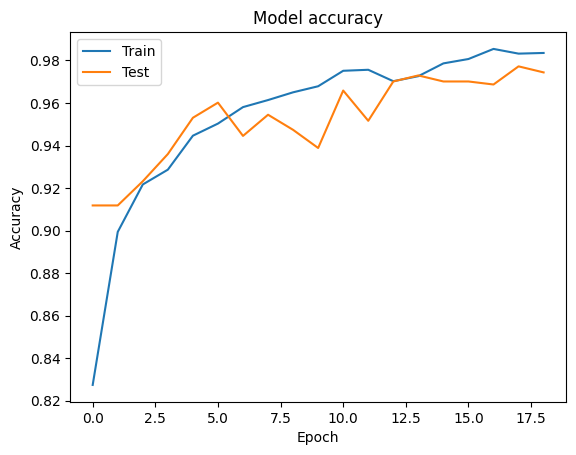

In [13]:
import matplotlib.pyplot as plt
history = history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

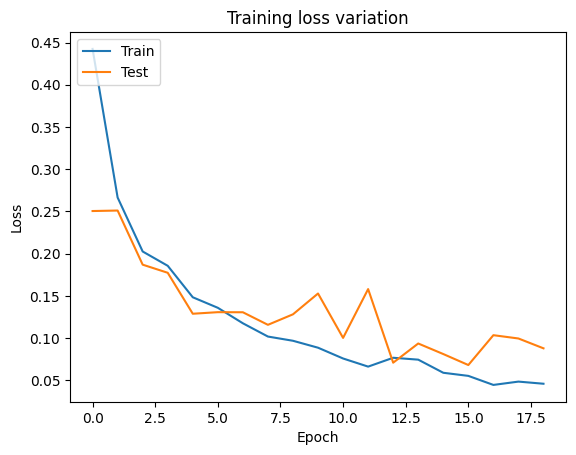

In [14]:
plt.plot(np.array(history["loss"]))
plt.plot(np.array(history["val_loss"]))
plt.title('Training loss variation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 790ms/step
Test Accuracy: 0.9743954480796586
---- Test Results ----
1 .


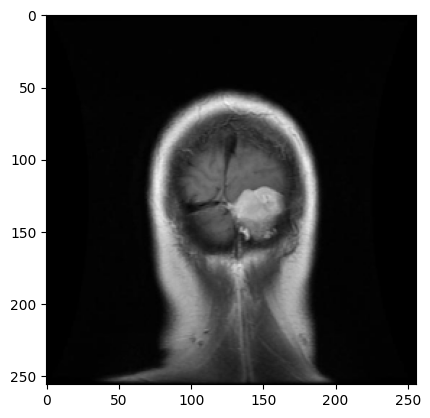

Actual: meningioma
Predicted: meningioma
Confidence: 99.993%
2 .


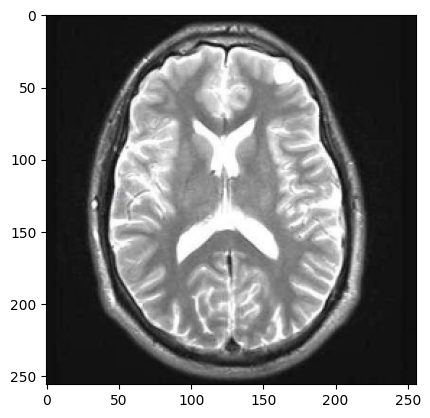

Actual: healthy
Predicted: healthy
Confidence: 99.9994%
3 .


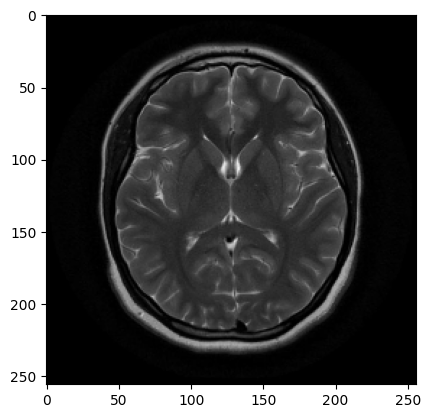

Actual: healthy
Predicted: healthy
Confidence: 99.9843%
4 .


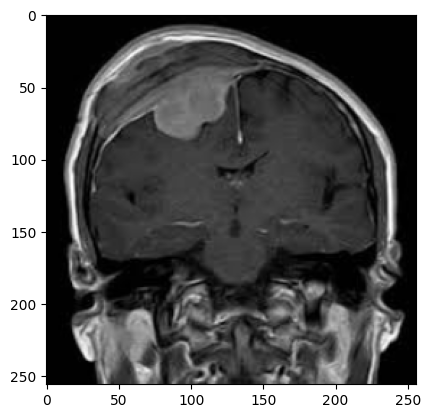

Actual: meningioma
Predicted: meningioma
Confidence: 99.9354%
5 .


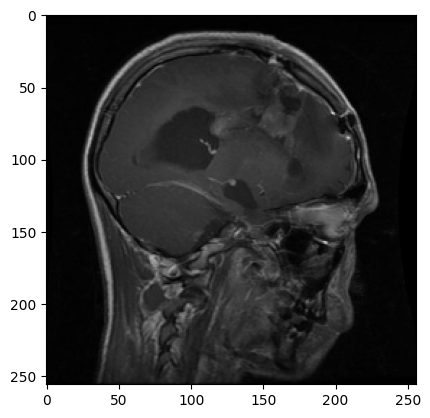

Actual: glioma
Predicted: glioma
Confidence: 99.9954%
6 .


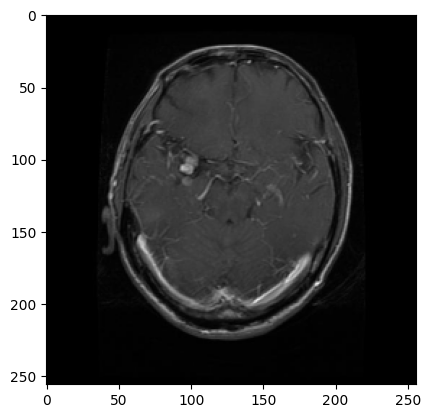

Actual: glioma
Predicted: glioma
Confidence: 100.0%
7 .


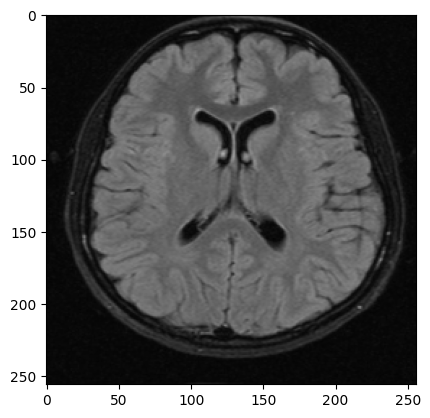

Actual: healthy
Predicted: healthy
Confidence: 100.0%
8 .


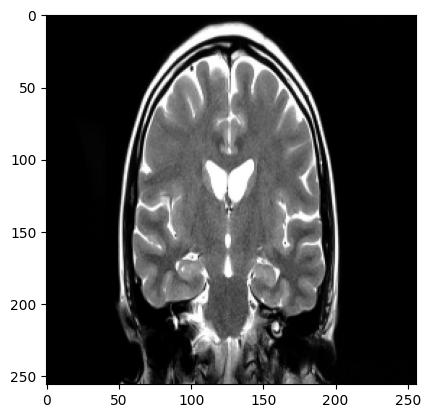

Actual: healthy
Predicted: healthy
Confidence: 99.9976%
9 .


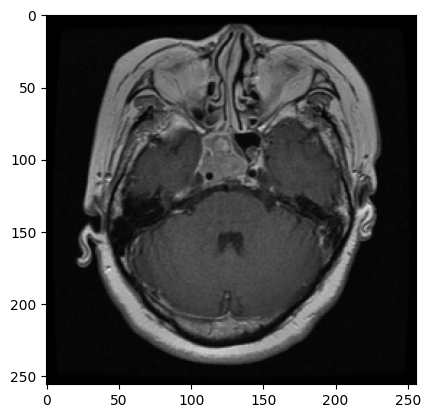

Actual: pituitary
Predicted: pituitary
Confidence: 99.9996%
10 .


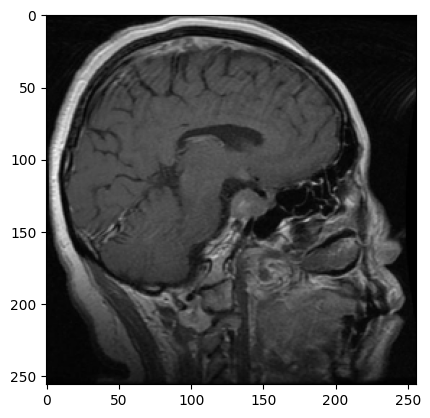

Actual: pituitary
Predicted: pituitary
Confidence: 99.9992%
11 .


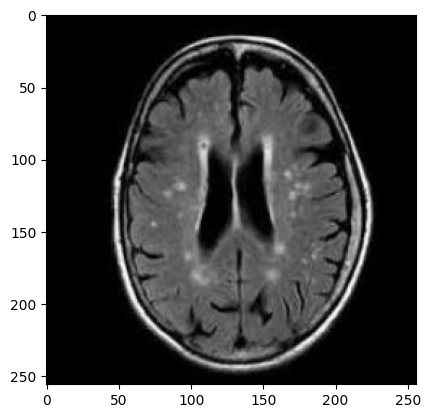

Actual: healthy
Predicted: healthy
Confidence: 99.9992%
12 .


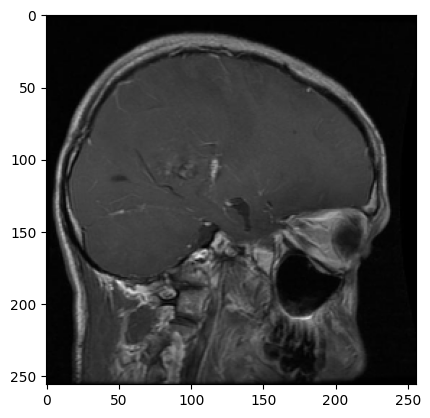

Actual: glioma
Predicted: glioma
Confidence: 99.9568%
13 .


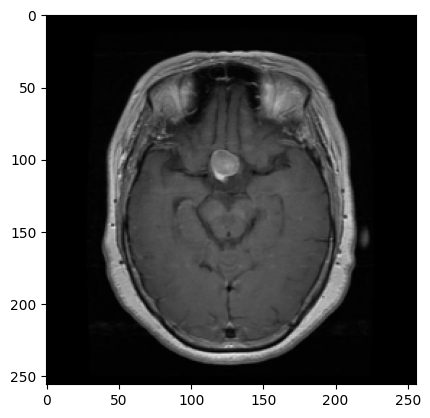

Actual: pituitary
Predicted: pituitary
Confidence: 99.6649%
14 .


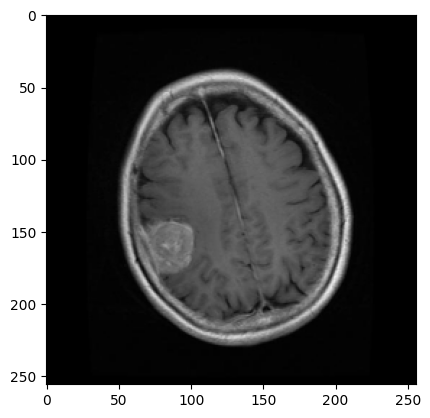

Actual: meningioma
Predicted: meningioma
Confidence: 98.8854%
15 .


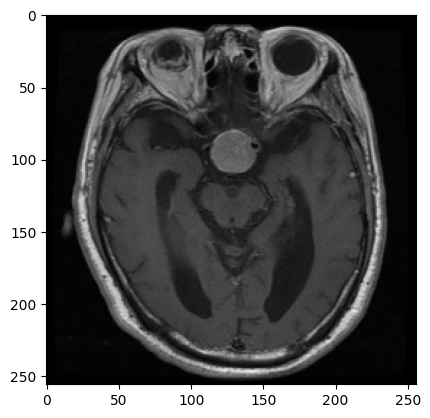

Actual: pituitary
Predicted: pituitary
Confidence: 99.7266%


In [15]:
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

test_accuracy = np.sum(y_pred_classes == np.array([labels_dict[i] for i in y_test])) / len(y_test)
print("Test Accuracy:", test_accuracy)

print("---- Test Results ----")
for i in range(15):
    print(i+1,".")
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.show()
    print(f"Actual: {list(labels_dict.keys())[y_pred_classes[i]]}")
    print(f"Predicted: {y_test[i]}")
    print(f"Confidence: {round(y_pred[i][y_pred_classes[i]]*100, 4)}%")

In [18]:
base_model.trainable = True
model1 = model


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(
         np.array(X_train), np.array([labels_dict[i] for i in y_train]), epochs=100,
                    validation_data=(np.array(X_test), np.array([labels_dict[i] for i in y_test])),
                    callbacks=[early_stopping]
)


Epoch 1/100


I0000 00:00:1728815877.678362      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 172 bytes spill stores, 172 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 180 bytes spill stores, 180 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 232 bytes spill stores, 236 bytes spill loads



198/198 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.7702 - loss: 0.9253 - val_accuracy: 0.8393 - val_loss: 0.7684
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 169s 853ms/step - accuracy: 0.9227 - loss: 0.2449 - val_accuracy: 0.8321 - val_loss: 0.8034
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 169s 852ms/step - accuracy: 0.9532 - loss: 0.1343 - val_accuracy: 0.8051 - val_loss: 0.8112


22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step
Test Accuracy: 0.9743954480796586
---- Test Results ----
1 .


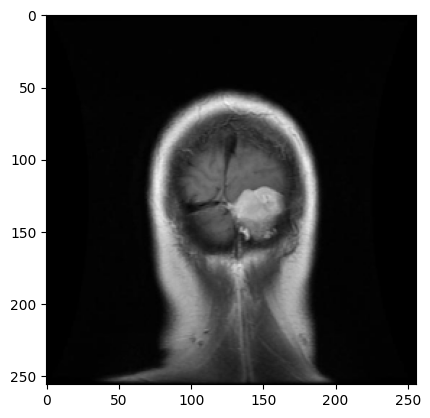

Actual: meningioma
Predicted: meningioma
Confidence: 99.993%
2 .


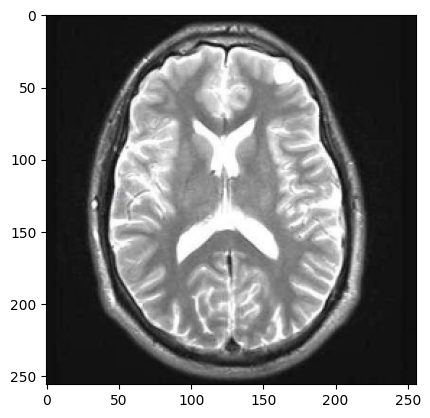

Actual: healthy
Predicted: healthy
Confidence: 99.9994%
3 .


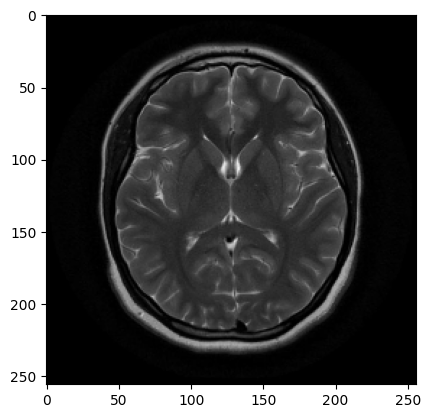

Actual: healthy
Predicted: healthy
Confidence: 99.9843%
4 .


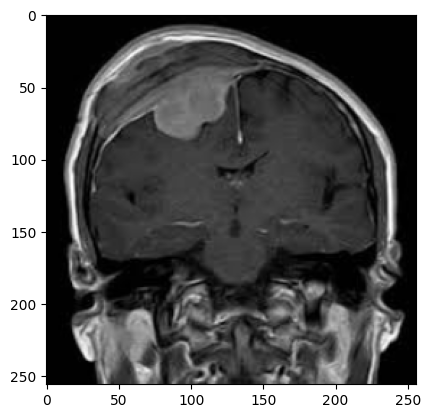

Actual: meningioma
Predicted: meningioma
Confidence: 99.9354%
5 .


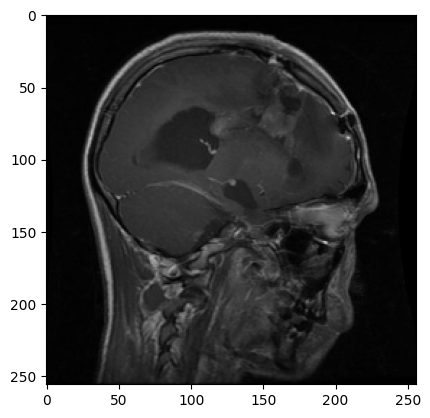

Actual: glioma
Predicted: glioma
Confidence: 99.9954%
6 .


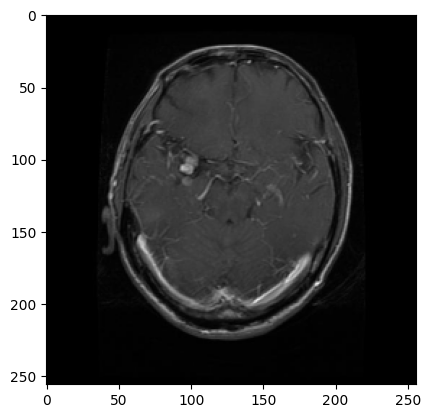

Actual: glioma
Predicted: glioma
Confidence: 100.0%
7 .


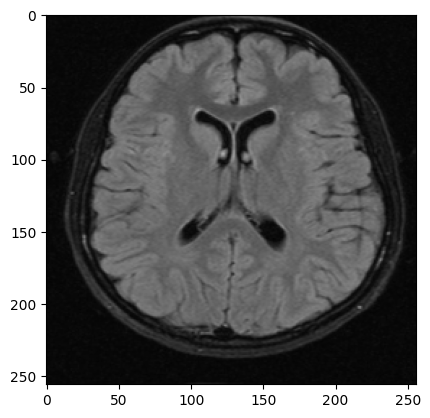

Actual: healthy
Predicted: healthy
Confidence: 100.0%
8 .


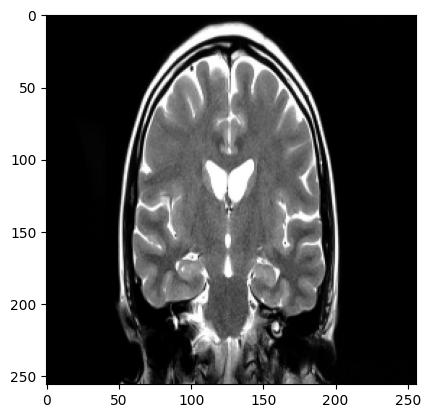

Actual: healthy
Predicted: healthy
Confidence: 99.9976%
9 .


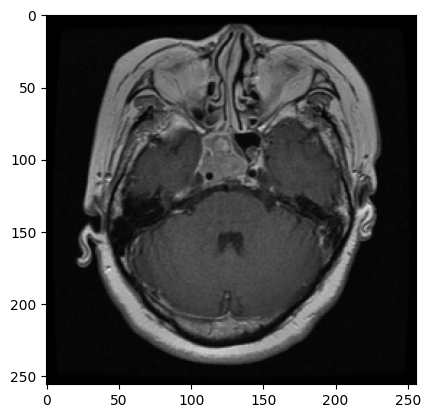

Actual: pituitary
Predicted: pituitary
Confidence: 99.9996%
10 .


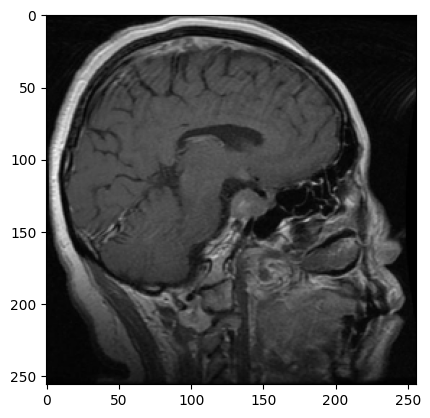

Actual: pituitary
Predicted: pituitary
Confidence: 99.9992%
11 .


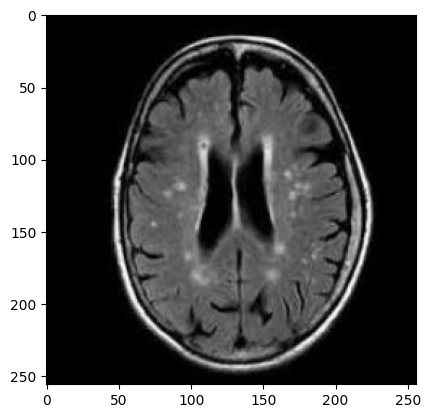

Actual: healthy
Predicted: healthy
Confidence: 99.9992%
12 .


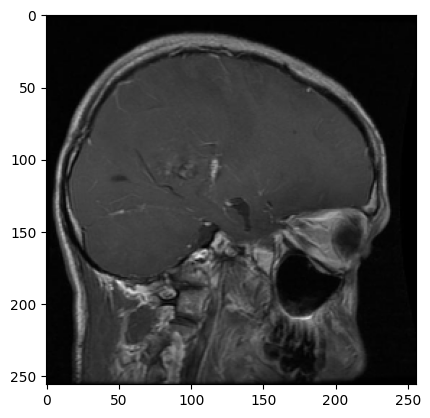

Actual: glioma
Predicted: glioma
Confidence: 99.9568%
13 .


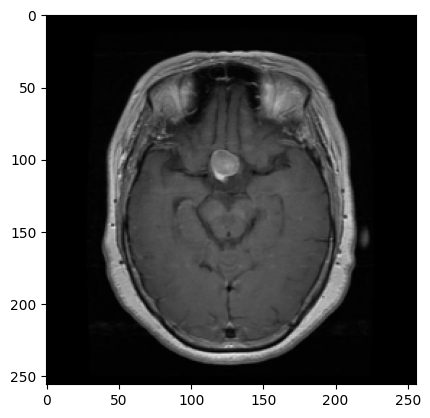

Actual: pituitary
Predicted: pituitary
Confidence: 99.6649%
14 .


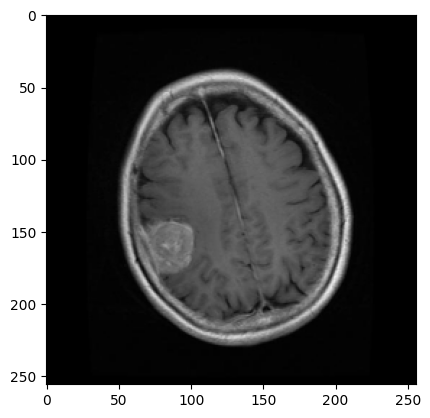

Actual: meningioma
Predicted: meningioma
Confidence: 98.8854%
15 .


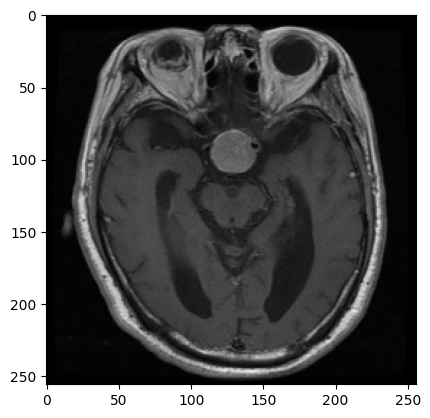

Actual: pituitary
Predicted: pituitary
Confidence: 99.7266%


In [19]:
y_pred1 = model1.predict(np.array(X_test))

test_accuracy = np.sum(y_pred_classes == np.array([labels_dict[i] for i in y_test])) / len(y_test)
print("Test Accuracy:", test_accuracy)

print("---- Test Results ----")
for i in range(15):
    print(i+1,".")
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.show()
    print(f"Actual: {list(labels_dict.keys())[y_pred_classes[i]]}")
    print(f"Predicted: {y_test[i]}")
    print(f"Confidence: {round(y_pred[i][y_pred_classes[i]]*100, 4)}%")